##### Project 2 - Big-Scale Analysis 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [8]:
# A disaster tweet
disaster_tweet = train[train['Target'] == 1]['Tweet text']
disaster_tweet.values[1]

'Governor allows parole for California school bus hijacker: Local... http://t.co/tAM6aoskoJ http://t.co/eL24mnFcHw'

In [9]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['Target'] == 0]['Tweet text']
non_disaster_tweet.values[1]

"Am now repped by the fantastic Laura Milne @TheJonesesVoice for all your liguistic needs. And that's some tongue twister tweets"

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries

In [39]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# sklearn for classification models
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alixm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# II. EDA

## 1. Training set

### Data loading

In [2]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

(7613, 5)

In [3]:
train.columns = ['ID', 'Keyword', 'Location', 'Tweet text', 'Target']
train.head()

,ID,Keyword,Location,Tweet text,Target
6421,9181,suicide%20bomber,NaN,@bbclaurak Why is no one talking about the ris...,1
4374,6215,hijacker,NaN,Governor allows parole for California school b...,1
659,953,blaze,302,Yo I got bars and I'm not even a rapper,0
7015,10056,twister,london,Am now repped by the fantastic Laura Milne @Th...,0
6351,9081,structural%20failure,"ÌÏT: 27.9136024,-81.6078532",'@CatoInstitute: The causes of federal failure...,0


### Distribution of the target column

In [4]:
#when the target = 1 it means the the tweet is about a disaster
train_yes = train.query('Target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters (Target = 0).')

#when the target = 0 it means the the tweet is not about a disaster
train_no = train.query('Target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters (Target = 1).')

There are 3271 tweets about disasters (Target = 0).
There are 4342 tweets that are not about disasters (Target = 1).


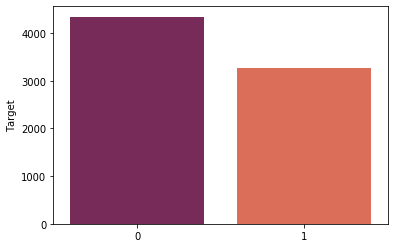

In [5]:
sns.barplot(train['Target'].value_counts().index, train['Target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

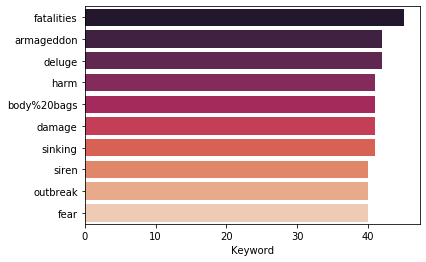

In [10]:
sns.barplot(y = train['Keyword'].value_counts()[:10].index, x = train['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [11]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

1    102
0     40
Name: Target, dtype: int64

## 2. Test set

### Data loading

In [12]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

(3263, 4)

In [13]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

,ID,Keyword,Location,Tweet text
1741,5871,hailstorm,Philippines,Hundreds of commuters abandoned at LRT station...
1980,6677,landslide,NaN,I liked a @YouTube video from @seeiey http://t...
1103,3630,desolation,NaN,'I See Fire' Ed Sheeran The Hobbit: The Desola...
318,1033,bleeding,??????????? :P,#Nepal: This house near TIA bleeding intÛªl a...
2518,8398,sandstorm,NaN,Watch This Airport Get Swallowed Up By A Sands...


### Distribution of the Keyword column

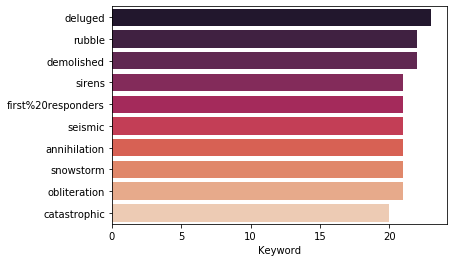

In [14]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [15]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

6421    bbclaurak why is no one talking about the risk...
4374    governor allows parole for california school b...
659                yo i got bars and im not even a rapper
7015    am now repped by the fantastic laura milne the...
6351    catoinstitute the causes of federal failure ar...
Name: Tweet text, dtype: object

In [16]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

1741    hundreds of commuters abandoned at lrt station...
1980    i liked a youtube video from seeiey  seeley  l...
1103    i see fire ed sheeran the hobbit the desolatio...
318     nepal this house near tia bleeding intûªl air...
2518    watch this airport get swallowed up by a sands...
Name: Tweet text, dtype: object

In [17]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

6421    [bbclaurak, why, is, no, one, talking, about, ...
4374    [governor, allows, parole, for, california, sc...
659     [yo, i, got, bars, and, im, not, even, a, rapper]
7015    [am, now, repped, by, the, fantastic, laura, m...
6351    [catoinstitute, the, causes, of, federal, fail...
Name: Tweet text, dtype: object

In [18]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

1741    [hundreds, of, commuters, abandoned, at, lrt, ...
1980    [i, liked, a, youtube, video, from, seeiey, se...
1103    [i, see, fire, ed, sheeran, the, hobbit, the, ...
318     [nepal, this, house, near, tia, bleeding, int,...
2518    [watch, this, airport, get, swallowed, up, by,...
Name: Tweet text, dtype: object

In [19]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

6421    [bbclaurak, one, talking, risk, suicide, bombe...
4374    [governor, allows, parole, california, school,...
659                     [yo, got, bars, im, even, rapper]
7015    [repped, fantastic, laura, milne, thejonesesvo...
6351    [catoinstitute, causes, federal, failure, deep...
Name: Tweet text, dtype: object

In [20]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

1741    [hundreds, commuters, abandoned, lrt, station,...
1980    [liked, youtube, video, seeiey, seeley, landsl...
1103    [see, fire, ed, sheeran, hobbit, desolation, s...
318     [nepal, house, near, tia, bleeding, int, ûªl, ...
2518    [watch, airport, get, swallowed, sandstorm, mi...
Name: Tweet text, dtype: object

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [35]:
from sklearn.model_selection import train_test_split

X = train['Tweet text']
ylabels = train['Target']


print('X shape: ', X.shape)
print('y shape: ', ylabels.shape)

X.head()

X shape:  (7613,)
y shape:  (7613,)


6421    [bbclaurak, one, talking, risk, suicide, bombe...
4374    [governor, allows, parole, california, school,...
659                     [yo, got, bars, im, even, rapper]
7015    [repped, fantastic, laura, milne, thejonesesvo...
6351    [catoinstitute, causes, federal, failure, deep...
Name: Tweet text, dtype: object

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['Tweet text'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['Tweet text'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['Target']

X_train.shape

(7613, 16222)

In [56]:
BNB = BernoulliNB()
scores = cross_val_score(BNB, X_train, y_train)
print(scores.mean())

0.7962688898538212


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [57]:
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
scores = cross_val_score(knn, X_train, y_train)
print(scores.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7074728442058712
